# Causal inference

## Propensity score matching

#### Problem statement:
Groupon deals have minimal requirement i.e. deal only works when there are at least 100 committed buyers. <br> Control: deals without the minimal requirement; Treatment: deals with minimmal requirement <br> We want to know whether having minimal requirement affect the deal outcomes, such as revenue, quantity sold, and Facebook likes received.

In [2]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()  # set the style

In [3]:
df = pd.read_csv('groupon.csv')
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deal_id          710 non-null    object
 1   start_date       710 non-null    object
 2   min_req          710 non-null    int64 
 3   treatment        710 non-null    int64 
 4   prom_length      710 non-null    int64 
 5   price            710 non-null    int64 
 6   discount_pct     710 non-null    int64 
 7   coupon_duration  710 non-null    int64 
 8   featured         710 non-null    int64 
 9   limited_supply   710 non-null    int64 
 10  fb_likes         710 non-null    int64 
 11  quantity_sold    710 non-null    int64 
 12  revenue          710 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 72.2+ KB


In [5]:
df.groupby('treatment').mean()

,min_req,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
treatment,,,,,,,,,,
0,1.00000,3.809717,37.870445,52.973684,95.941296,0.105263,0.852227,77.941296,333.002024,9720.987854
1,26.50463,3.379630,29.421296,53.263889,131.842593,0.143519,0.777778,113.203704,509.351852,12750.694444


In [6]:
# t-test before PSM
# separate control and treatment for t-test
df_control = df[df.treatment==0]
df_treatment = df[df.treatment==1]

In [7]:
# student's t-test for revenue (dependent variable)
from scipy.stats import ttest_ind

print(df_control.revenue.mean(), df_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_control.revenue, df_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9720.987854251012 12750.694444444445
p=0.040
different distributions/different group mean (reject H0)


In [8]:
# student's t-test for fb_likes (dependent variable)
from scipy.stats import ttest_ind

print(df_control.fb_likes.mean(), df_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_control.fb_likes, df_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

77.9412955465587 113.20370370370371
p=0.004
different distributions/different group mean (reject H0)


In [9]:
# PSM: choose features for propensity score calculation
X = df[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'limited_supply']]
y = df['treatment']
X.head()

,prom_length,price,discount_pct,coupon_duration,featured,limited_supply
0,4,99,51,185,1,1
1,2,95,41,9,0,1
2,3,25,50,38,0,1
3,3,50,50,369,0,1
4,4,25,52,185,0,1


In [10]:
# fitting the model
from sklearn.linear_model import LogisticRegression
# Initialize the model
model = LogisticRegression()
# Train the model
result = model.fit(X, y)
# Make prediction
pred_binary = model.predict(X) # binary prediction
pred_prob = model.predict_proba(X) # corresponding probabilities for binary prediction 0 and 1

# Print coefficients
coefficients = model.coef_
pd.DataFrame({'column': X.columns, 'coeff': coefficients.ravel()}).rename(columns = {'column': 'feature'})
# for i, feature in enumerate(X.columns):
#     print(f"Feature: {feature}, Coefficient: {coefficients[0][i]}")

,feature,coeff
0,prom_length,-0.328371
1,price,-0.008597
2,discount_pct,-0.007940
3,coupon_duration,0.003520
4,featured,0.307996
5,limited_supply,-0.366498


In [11]:
# propensity score (ps) is the probability of being 1
df['ps'] = pred_prob[:, 1]
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460,0.259193
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050,0.230198
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500,0.288405
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500,0.511781
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500,0.325212


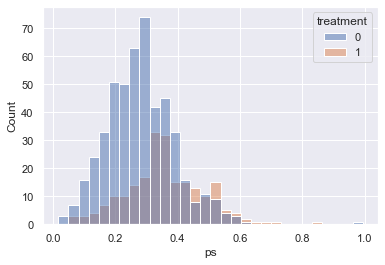

In [12]:
# check overlap of ps for control and treatmment using histogram
sns.histplot(data = df, x = 'ps', hue = 'treatment')
# The figure above shows major overlaps of the propensity scores in the control and treatment group, which is a good foundation for the matching, 
# i.e., if there are no or few overlaps, it’s impossible/difficult to find enough matches.

In [13]:
# we should not include 'min_req' and 'start_date' in ps prediction as treatment is derived from min_req and start_date is highly correlated with min_req or revenue

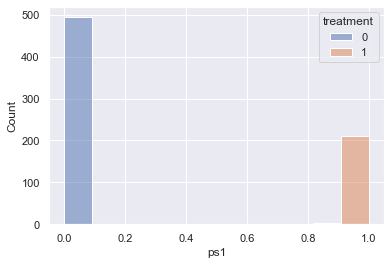

In [14]:
# adding 'min_req' here makes matching not working - because treatment is derived from min_req
# there is no overlap and thus matching will not work
X1 = df[['min_req', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X1, y)

pred_prob1 = lr1.predict_proba(X1)  # probabilities for classes
df['ps1'] = pred_prob1[:, 1]

sns.histplot(data=df, x='ps1', hue='treatment')

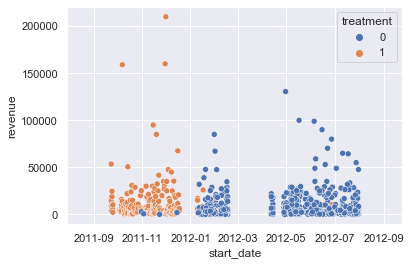

In [15]:
# start date is highly correlated with min_req or revenue
df.start_date = pd.to_datetime(df.start_date)
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, x='start_date', y='revenue', hue='treatment')

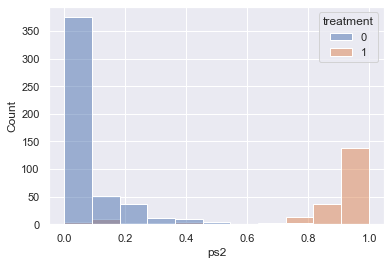

In [16]:
# adding 'starting_date' here via a `recency` feature
# there is only little overlap resulting in not enough matched observations

last_date = df.start_date.max()
df['recency'] = (last_date - df.start_date).dt.days

X2 = df[['recency', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X2, y)

pred_prob2 = lr2.predict_proba(X2)  # probabilities for classes
df['ps2'] = pred_prob2[:, 1]

sns.histplot(data=df, x='ps2', hue='treatment')

In [17]:
# Propensity score matching

In [18]:
from sklearn.neighbors import NearestNeighbors

# use 25% of standard deviation of the propensity score as the caliper/radius
# relax caliper and increase k can provide more matches
caliper = np.std(df.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

# setup knn: get k closest neighbors for each observations
n_neighbors = 10
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)
ps = df[['ps']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0304


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=0.03037912483409167)

In [19]:
# distances and indexes
distances, neighbor_indexes = knn.kneighbors(ps)
print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

(710, 10)
[0.         0.00010819 0.00040688 0.0007821  0.00115812 0.00135198
 0.00135198 0.00164948 0.00166937 0.00203865]
[  0 348 388 415 624 150 494 463 372 345]


In [20]:
# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control

matched_control = []  # keep track of the matched observations in control

for current_index, row in df.iterrows():  # iterate over the dataframe
    if row.treatment == 0:  # the current row is in the control group
        df.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself and the neighbor is in the control 
            if (current_index != idx) and (df.loc[idx].treatment == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    df.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

In [21]:
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps1,recency,ps2,matched
0,heli-flights,2011-09-23,10,1,4,99,51,185,1,1,290,540,53460,0.259193,1.0,312,0.998459,348.0
1,gl-champion-series-tennis-electric-factory,2011-09-23,20,1,2,95,41,9,0,1,43,190,18050,0.230198,1.0,312,0.995757,403.0
2,realm-of-terror-horror-experience,2011-09-23,50,1,3,25,50,38,0,1,208,380,9500,0.288405,1.0,312,0.998066,512.0
3,newport-gourmet,2011-09-23,15,1,3,50,50,369,0,1,16,90,4500,0.511781,1.0,312,0.998164,679.0
4,the-clayroom,2011-09-23,20,1,4,25,52,185,0,1,85,580,14500,0.325212,1.0,312,0.998570,690.0


In [ ]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment:', len(df[df.treatment==1]))
print('total matched observations in control:', len(matched_control))

In [22]:
# control have no match
treatment_matched = df.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched = pd.concat([treatment_matched, control_matched])

df_matched.treatment.value_counts()

1    185
0    185
Name: treatment, dtype: int64

In [23]:
# matched control and treatment after propensity score matching
df_matched_control = df_matched[df_matched.treatment==0]
df_matched_treatment = df_matched[df_matched.treatment==1]

In [24]:
# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
from scipy.stats import ttest_ind
print(df_matched_control.revenue.mean(), df_matched_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_matched_control.revenue, df_matched_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9146.783783783783 13275.405405405405
p=0.051
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [25]:
# student's t-test for facebook likes(dependent variable) after matching
# p value is smaller compared with before matching
from scipy.stats import ttest_ind
print(df_matched_control.fb_likes.mean(), df_matched_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_matched_control.fb_likes, df_matched_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

68.0 115.75135135135135
p=0.002
different distributions/different group mean (reject H0)


In [26]:
# One way to see the matching effect is to show the mean difference of the features from control vs. treatment groups before and after the match - 
# we hope to decrease the differences via matching, i.e., the characteristics of the deals are more similar in both control and treatment groups after matching.

In [27]:
df_matched.groupby('treatment').mean()

,min_req,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps1,recency,ps2,matched
treatment,,,,,,,,,,,,,,,
0,1.000000,3.508108,31.351351,52.183784,121.989189,0.151351,0.762162,68.000000,364.783784,9146.783784,0.337784,0.004993,98.702703,0.069864,NaN
1,26.940541,3.437838,31.221622,53.124324,117.329730,0.140541,0.794595,115.751351,489.513514,13275.405405,0.337754,0.990306,256.621622,0.871881,472.372973


In [28]:
df.groupby('treatment').mean()

,min_req,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps1,recency,ps2,matched
treatment,,,,,,,,,,,,,,,
0,1.00000,3.809717,37.870445,52.973684,95.941296,0.105263,0.852227,77.941296,333.002024,9720.987854,0.280741,0.004535,89.969636,0.062920,NaN
1,26.50463,3.379630,29.421296,53.263889,131.842593,0.143519,0.777778,113.203704,509.351852,12750.694444,0.357931,0.989627,253.273148,0.856101,472.372973


# Appendix

https://harrywang.me/psm-did

https://www.kaggle.com/code/harrywang/propensity-score-matching-in-python

https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html